In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Angela\ANACONDA\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
import pandas as pd
skinceuticals = pd.read_csv("tweets_skinceuticals.csv")
skinceuticals = skinceuticals.drop(['Unnamed: 0', 'Date', 'User'], axis=1)

## Data Cleaning

In [3]:
skinceuticals.head()

,Tweet
0,SkinCeuticals Biocellulose Restorative Mask (6...
1,SkinCeuticals Clarifying Clay Mask (2.4 oz.)\n...
2,SkinCeuticals Phyto Corrective Mask (2 fl. oz....
3,"SKINCEUTICALS Hydrating B5 Gel, 1 Fl Oz THKBED..."
4,SkinCeuticals Hydrating B5 Mask (2.5 fl. oz.)\...


### Remove punctuation, special characters and lower casing

In [4]:
# 1 - Text cleaning
def clean_up(s):
    clean = re.sub(r'http\S+', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean).lower().strip()

def clean_up2(s):
    clean2 = re.sub(r'\W*\b\w{1,3}\b', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean2).lower().strip()

In [5]:
# In order to avoid errors, change type to string
skinceuticals['Tweet'] = skinceuticals['Tweet'].apply(str)  # change to string for avoiding errors

In [6]:
skinceuticals['Tweet_Processed'] = skinceuticals['Tweet'].apply(clean_up).apply(clean_up2)
skinceuticals

,Tweet,Tweet_Processed
0,SkinCeuticals Biocellulose Restorative Mask (6...,skinceuticals biocellulose restorative mask ...
1,SkinCeuticals Clarifying Clay Mask (2.4 oz.)\n...,skinceuticals clarifying clay mask price der...
2,SkinCeuticals Phyto Corrective Mask (2 fl. oz....,skinceuticals phyto corrective mask price de...
3,"SKINCEUTICALS Hydrating B5 Gel, 1 Fl Oz THKBED...",skinceuticals hydrating thkbedo
4,SkinCeuticals Hydrating B5 Mask (2.5 fl. oz.)\...,skinceuticals hydrating mask price dermstor...
...,...,...
15586,@AXfromMN @SkinCeuticals It was ONE glass of c...,axfrommn skinceuticals glass champagne shower
15587,@bowlermikey @SkinCeuticals I’m old. You just ...,bowlermikey skinceuticals just think young be...
15588,@BlakeMcCoyDC @SkinCeuticals Never do your ski...,blakemccoydc skinceuticals never your skincar...
15589,@BlakeMcCoyDC @SkinCeuticals You're too young ...,blakemccoydc skinceuticals young that stuff a...


### Tokenize words and further clean-up text

In [7]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = skinceuticals.Tweet_Processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

C:\Users\Angela\ANACONDA\lib\site-packages\botocore\httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


['skinceuticals', 'biocellulose', 'restorative', 'mask', 'piece', 'price', 'dermstore', 'skincare']


### Phrase Modeling: Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [9]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['SA', 'link', '$', 'ohmybeautybank'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#pip install spacy

In [11]:
!python -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1][0][:30])

     --------------------------------------- 12.8/12.8 MB 16.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [12]:
data_words_bigrams

[['skinceuticals',
  'biocellulose_restorative',
  'mask',
  'piece',
  'price',
  'dermstore',
  'skincare'],
 ['skinceuticals',
  'clarifying_clay',
  'mask',
  'price',
  'dermstore',
  'skincare'],
 ['skinceuticals',
  'phyto_corrective',
  'mask',
  'price',
  'dermstore',
  'skincare'],
 ['skinceuticals', 'hydrating', 'thkbedo'],
 ['skinceuticals', 'hydrating', 'mask', 'price', 'dermstore', 'skincare'],
 ['itsmedejamarie',
  'skin',
  'externally',
  'flaky',
  'crusty',
  'gently',
  'exfoliate',
  'fine',
  'scrub',
  'like',
  'super',
  'duper',
  'juicy',
  'hydrating',
  'mask',
  'love',
  'skinceuticals',
  'phytocorrective',
  'mask'],
 ['skinceuticals',
  'serum',
  'deal_price',
  'skinceuticals',
  'brands',
  'dermstore'],
 ['skinceuticals',
  'physical_matte',
  'defense',
  'deal_price',
  'skinceuticals',
  'brands',
  'dermstore'],
 ['skinceuticals',
  'phyto_corrective',
  'essence_mist',
  'deal_price',
  'skinceuticals',
  'brands',
  'dermstore'],
 ['skinceut

In [13]:
data_lemmatized

[['skinceutical',
  'biocellulose_restorative',
  'mask',
  'piece',
  'price',
  'dermstore',
  'skincare'],
 ['skinceutical', 'clarifying_clay', 'mask', 'price', 'dermstore', 'skincare'],
 ['skinceutical',
  'phyto_corrective',
  'mask',
  'price',
  'dermstore',
  'skincare'],
 ['skinceutical', 'hydrate'],
 ['skinceutical', 'hydrate', 'mask', 'price', 'skincare'],
 ['externally',
  'flaky',
  'crusty',
  'gently',
  'exfoliate',
  'fine',
  'scrub',
  'super',
  'duper',
  'juicy',
  'mask',
  'love',
  'skinceutical',
  'phytocorrective',
  'mask'],
 ['skinceutical', 'serum', 'deal_price', 'skinceutical', 'brand', 'dermstore'],
 ['skinceutical',
  'physical_matte',
  'defense',
  'deal_price',
  'skinceutical',
  'brand',
  'dermstore'],
 ['skinceutical',
  'phyto_corrective',
  'essence_mist',
  'deal_price',
  'skinceutical',
  'brand',
  'dermstore'],
 ['skinceutical', 'repair', 'skinceutical', 'brand', 'dermstore'],
 ['skinceutical',
  'replenish',
  'cleanser',
  'deal_price',

### Data Transformation: Corpus and Dictionary

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

# It is creating a dictionary with the order of words and their frequency in the dataset
# For instance, if first word was able, it would indicate it appears 1 time in the dictionary

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


### Base Model

In [15]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### View the topics in LDA model

In [16]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.111*"skin" + 0.048*"skinceutical" + 0.020*"help" + 0.018*"cleanser" + '
  '0.015*"hydrate" + 0.014*"improve" + 0.013*"daily" + 0.012*"serum" + '
  '0.012*"restore" + 0.011*"brighten"'),
 (1,
  '0.112*"skinceutical" + 0.038*"love" + 0.037*"product" + 0.024*"use" + '
  '0.020*"year" + 0.020*"drskinceutical" + 0.018*"well" + 0.017*"good" + '
  '0.015*"amazing" + 0.015*"work"'),
 (2,
  '0.104*"cream" + 0.089*"skinceutical" + 0.089*"retinol" + 0.029*"night" + '
  '0.023*"discover" + 0.019*"difference" + 0.019*"cleansing" + '
  '0.018*"good_share" + 0.017*"loving_poshmarkapp" + 0.016*"filler"'),
 (3,
  '0.054*"sunscreen" + 0.038*"skinceutical" + 0.024*"sign" + 0.020*"masque" + '
  '0.016*"summer" + 0.016*"defense" + 0.016*"perfect" + 0.015*"peel" + '
  '0.015*"effective" + 0.014*"hydrafacial"'),
 (4,
  '0.095*"skinceutical" + 0.056*"skin" + 0.042*"skincare" + 0.037*"product" + '
  '0.024*"discoloration" + 0.022*"defense" + 0.022*"care" + 0.019*"brand" + '
  '0.017*"shop" + 0.013*"t

### Compute Model Perplexity and Coherence Score

In [17]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40897486698619756


### Hyperparameter Tuning

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
coherence_model_lda

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_skinceuticals.csv', index=False)
    pbar.close()

 99%|█████████▉| 537/540 [8:03:11<02:49, 56.49s/it]    

In [18]:
result = pd.read_csv("lda_tuning_results_skinceuticals.csv")
result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.325159
1,75% Corpus,2,0.01,0.31,0.409128
2,75% Corpus,2,0.01,0.61,0.419968
3,75% Corpus,2,0.01,0.9099999999999999,0.426491
4,75% Corpus,2,0.01,symmetric,0.419968
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.376475
536,100% Corpus,10,asymmetric,0.31,0.403081
537,100% Corpus,10,asymmetric,0.61,0.412072
538,100% Corpus,10,asymmetric,0.9099999999999999,0.386847


In [19]:
#calculate mean of points grouped by topics -- REVISAR
topics = result.groupby('Topics')['Coherence'].mean()
topics

Topics
2     0.349910
3     0.391880
4     0.385775
5     0.426631
6     0.419410
7     0.407519
8     0.403821
9     0.401218
10    0.404150
Name: Coherence, dtype: float64

In [20]:
# Generated by OPEN AI 
import pandas as pd

# Define the data as lists
topics = [2, 3, 4, 5, 6, 7, 8, 9, 10]
coherence = [0.349910, 0.391880, 0.385775, 0.426631, 0.419410, 0.407519, 0.403821, 0.401218, 0.404150]

# Combine the data into a DataFrame
df = pd.DataFrame({'Topics': topics, 'Coherence': coherence})

In [21]:
df

,Topics,Coherence
0,2,0.349910
1,3,0.391880
2,4,0.385775
3,5,0.426631
4,6,0.419410
5,7,0.407519
6,8,0.403821
7,9,0.401218
8,10,0.404150


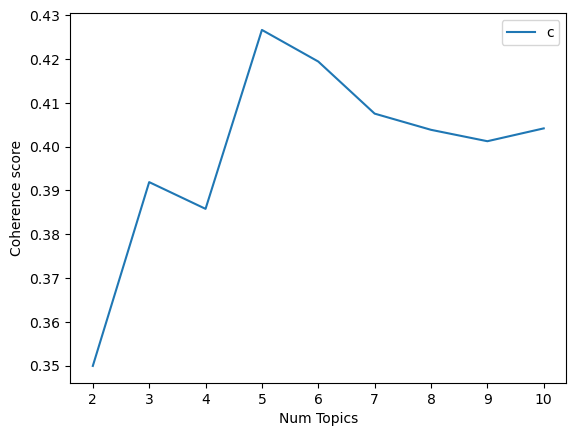

In [22]:
# Show graph -- fix it!
limit=40; start=2; step=6;
x = df['Topics']
y = df['Coherence']
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Final Model

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R=30)
vis

C:\Users\Angela\ANACONDA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.376929 -0.040874       1        1  29.258752
3      0.153906  0.290446       2        1  28.855187
1     -0.312895 -0.223307       3        1  21.951982
0     -0.266358  0.237696       4        1  16.905536
2      0.048418 -0.263961       5        1   3.028542, topic_info=              Term          Freq         Total Category  logprob  loglift
6     skinceutical  15350.000000  15350.000000  Default  30.0000  30.0000
99            skin   4907.000000   4907.000000  Default  29.0000  29.0000
632           free   1842.000000   1842.000000  Default  28.0000  28.0000
5         skincare   2384.000000   2384.000000  Default  27.0000  27.0000
97         product   2241.000000   2241.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1450          fuck     17.849211     18.581231   Topic5  -5.5246   3.4569
1643          none     17.908758     18.660971   Topic5  -5.5213   3.4559
2931        remain     16.504849     17.246963   Topic5  -5.6029   3.4531
8910        butter     21.037292     23.427710   Topic5  -5.3603   3.3895
8875       profile     18.872506     23.972801   Topic5  -5.4688   3.2579

[185 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
436       2  0.998437             acid
437       2  0.998931             acne
73        1  0.997855              age
424       5  0.963855  alastinskincare
84        2  0.999020             also
...     ...       ...              ...
2253      5  0.987603        wonderful
211       3  0.999362             work
67        4  0.996861            worth
577       3  0.997620          wrinkle
501       2  0.997955             year

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [25]:
pyLDAvis.save_html(vis, 'lda_visualization_skinceuticals.html')